In [1]:
import numpy as np
import pandas as pd
import time
import gymnasium.spaces as spaces
from rlberry.agents import AgentWithSimplePolicy
from rlberry_scool.agents import UCBVIAgent
from rlberry_scool.envs import Chain
from rlberry_research.envs.benchmarks.grid_exploration.nroom import NRoom
from rlberry.manager import(
    ExperimentManager,
    evaluate_agents,
    plot_writer_data,
    read_writer_data,
)

/Users/chengruiqu/anaconda3/envs/rlberry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# define BPI-UCBVI agent
from rlberry.agents import AgentWithSimplePolicy
from rlberry.utils.writers import DefaultWriter
class AdaptiveAgent(AgentWithSimplePolicy):
    name="AdaptiveAgent"
    def __init__(
            self,
            env,
            gamma=1,
            horizon=100,
            delta=0.1,
            varepsilon=0.1,
            **kwargs
    ):
        # init base class
        AgentWithSimplePolicy.__init__(self,env=env,**kwargs)

        self.gamma=gamma
        self.horizon=horizon
        self.varepsilon=varepsilon
        self.delta=delta
        self.initial_state,_=self.env.reset()
        self.S=self.env.observation_space.n
        self.A=self.env.action_space.n
        self.bonus=np.ones((self.S,self.A))*self.horizon #should multiply H
        self.P_hat=np.ones((self.S,self.A,self.S))*1.0/self.S #estimated transition kernel
        self.Nsas=np.zeros((self.S,self.A,self.S)) #visitation count of (s,a,s')
        self.Nsa=np.zeros((self.S,self.A)) #visitation count of (s,a)
        self.R_hat=np.zeros((self.S,self.A))
        #upper and lower confidence bound
        self.q_max=np.zeros((self.horizon,self.S,self.A))
        self.q_min=np.zeros((self.horizon,self.S,self.A))
        self.v_max=np.zeros((self.horizon,self.S))
        self.v_min=np.zeros((self.horizon,self.S))
        # self.v=np.zeros((self.horizon,self.S,self.A))
        #optimality gap upper bound
        self.G=np.ones((self.horizon,self.S,self.A)) #should multiply H

        
    def fit(self,budget,**kwargs):
        """
        The parameter budget can represent the number of steps, the number of episodes etc,
        depending on the agent.
        * Interact with the environment (self.env);
        * Train the agent
        * Return useful information
        """
        T=budget
        rewards=np.zeros(T)
        for t in range(T):
            if ((t+1)%100==0):
                print("Episode",t+1)
            self.update_value()
            # self.update_v()
            observation,info=self.env.reset()
            done=False
            step=0
            reward=0
            current_state=0
            while step<self.horizon:
                #terminal state is an absorbing state
                if done:
                    action=self.policy(current_state,step)
                    next_step=current_state
                    self.update(current_state,action,next_step,reward)
                else:
                    # print("Step",step+1)
                    action=self.policy(observation,step)
                    next_step,reward,terminated,truncated,info=self.env.step(action)
                    #update visitation count and policy
                    self.update(observation,action,next_step,reward)
                    current_state=observation
                    observation=next_step
                    done=terminated or truncated
                rewards[t]+=reward
                step+=1
            # if self.stop():
            #     break
        info={"episode_rewards": rewards}
        # print(self.v_max)
        return rewards
        
    def eval(self,**kwargs):
        """
        Returns a value corresponding to the evaluation of the agent on the
        evaluation environment.

        For instance, it can be a Monte-Carlo evaluation of the policy learned in fit().
        """
        return super().eval() #use the eval() from AgentWithSimplePolicy
    
    #calculate bonus
    def beta(self,n):
        beta = np.log(3*self.S*self.A*self.horizon/self.delta) + self.S*np.log(8*np.exp(1)*(n+1))
        return beta
    
    # update counts
    def update(self,s,a,next_state,r):
        self.Nsas[s,a,next_state]+=1
        self.Nsa[s,a]+=1

        n_sa=self.Nsa[s,a]
        n_sas=self.Nsas[s,a,:]
        self.P_hat[s,a,:]=n_sas/n_sa
        self.bonus[s,a]=self.beta(n_sa)/n_sa

        self.R_hat[s,a]=r
    
    # compute empirical variance
    def emvar(self,v,s,a):
        mean=np.dot(v,self.P_hat[s,a,:])
        var=var = np.dot(self.P_hat[s, a, :], (v - mean) ** 2)
        return var
    
    # compute \hat{p}\pi*G
    def backG(self,s,a,h):
        out=0
        for i in range(self.S):
            out+=self.P_hat[s,a,i]*self.G[h+1,i,self.policy(i,h+1)] #replace with self.policy(h+1,i)
        return out
    # def backV(self,s,a,h):
    #     out=0
    #     for i in range(self.S):
    #         out+=self.P_hat[s,a,i]*np.max(self.v[h+1,i,:])
    #     return out
    # def update_v(self):
    #     for h in range(self.horizon-1,-1,-1):
    #         if h==self.horizon-1:
    #             self.v[h,:,:]=self.R_hat+4*(self.Nsa+1)**(-1)
    #         else:
    #             for s in range(self.S):
    #                 for a in range(self.A):
    #                     self.v[h,s,a]=self.R_hat[s,a]+4*(self.Nsa[s,a]+1)**(-1)+self.backV(s,a,h)

    # update v_max v_min G                  
    def update_value(self):
        for h in range(self.horizon-1,-1,-1):
            if h==self.horizon-1:
                for s in range(self.S):
                    for a in range(self.A):
                        self.q_max[h,s,a]=min(self.horizon,self.R_hat[s,a]+0.00002*14*self.horizon**2*self.bonus[s,a])
                        self.q_min[h,s,a]=max(0,self.R_hat[s,a]-0.00002*14*self.horizon**2*self.bonus[s,a])
                        self.G[h,s,a]=min(self.horizon,0.00002*35*self.horizon**2*self.bonus[s,a])
                    self.v_max[h,s]=np.max(self.q_max[h,s,:])
                    self.v_min[h,s]=np.max(self.q_min[h,s,:])
            else:
                for s in range(self.S):
                    for a in range(self.A):
                        tmp1=np.dot(self.P_hat[s,a,:],self.v_max[h+1,:])
                        tmp2=np.dot(self.P_hat[s,a,:],self.v_min[h+1,:])
                        emvarV=self.emvar(self.v_max[h+1,:],s,a)
                        self.q_max[h,s,a]=min(self.horizon,self.R_hat[s,a]+0.00005*(3*np.sqrt(emvarV*self.bonus[s,a])+14*self.horizon**2*self.bonus[s,a]+(tmp1-tmp2)/self.horizon)+tmp1)
                        self.q_min[h,s,a]=max(0,self.R_hat[s,a]-0.00005*(3*np.sqrt(emvarV*self.bonus[s,a])-14*self.horizon**2*self.bonus[s,a]-(tmp1-tmp2)/self.horizon)+tmp2)
                        self.G[h,s,a]=min(self.horizon,0.00005*(6*np.sqrt(emvarV*self.bonus[s,a])+35*self.horizon**2*self.bonus[s,a])+(1+3/self.horizon)*self.backG(s,a,h))
                    self.v_max[h,s]=np.max(self.q_max[h,s,:])
                    self.v_min[h,s]=np.max(self.q_min[h,s,:])

    # define the agent's policy
    def policy(self,observation,h):
        return self.q_max[h,observation,:].argmax()
    
    # define stopping rule
    def stop(self):
        if self.G[0,self.initial_state,self.policy(self.initial_state,0)]<self.varepsilon/2:
            return True
        else:
            return False
    
    def policy2(self,observation,h):
        return self.v[h,observation,:].argmax()

In [16]:
# define HYBRID-TRANSFER agent
class HybridTransferAgent(AgentWithSimplePolicy):
    name="HybridTransferAgent"
    def __init__(
            self,
            env,
            source_count,
            source_transition,
            gamma=1,
            sigma=1,
            beta=0.9,
            horizon=100,
            delta=0.1,
            varepsilon=0.1,
            **kwargs
    ):
        # init base class
        AgentWithSimplePolicy.__init__(self,env=env,**kwargs)

        # basic parameters
        self.gamma=gamma
        self.horizon=horizon
        self.sigma=sigma
        self.gap=beta #beta separation
        self.varepsilon=varepsilon
        self.delta=delta
        self.initial_state,_=self.env.reset()
        self.S=self.env.observation_space.n
        self.A=self.env.action_space.n

        # experiences from a previous task
        self.source_count=source_count # dimension (S,A)
        self.source_transition=source_transition # dimension (S,A,S)

        # shifted area
        self.shifted_area=set() # contain tuple (s,a)

        # task information
        self.bonus=np.ones((self.S,self.A))*self.horizon #should multiply H
        self.P_hat=np.ones((self.S,self.A,self.S))*1.0/self.S #estimated transition kernel
        self.Nsas=np.zeros((self.S,self.A,self.S)) #visitation count of (s,a,s')
        self.Nsa=np.zeros((self.S,self.A)) #visitation count of (s,a)
        self.R_hat=np.zeros((self.S,self.A))

        # upper and lower confidence bound
        self.q_max=np.zeros((self.horizon,self.S,self.A))
        self.q_min=np.zeros((self.horizon,self.S,self.A))
        self.v_max=np.zeros((self.horizon,self.S))
        self.v_min=np.zeros((self.horizon,self.S))

        # optimality gap upper bound
        self.G=np.ones((self.horizon,self.S,self.A))

        # uncertainty function
        self.Whsa=np.ones((self.horizon,self.S,self.A))
    
    def eval(self,**kwargs):
        """
        Returns a value corresponding to the evaluation of the agent on the
        evaluation environment.

        For instance, it can be a Monte-Carlo evaluation of the policy learned in fit().
        """
        return super().eval() #use the eval() from AgentWithSimplePolicy
    
    #calculate bonus
    def beta(self,n):
        out = np.log(6*self.S*self.A*self.horizon/self.delta) + self.S*np.log(8*np.exp(1)*(n+1))
        return out
    
    # compute empirical variance
    def emvar(self,v,s,a):
        mean=np.dot(v,self.P_hat[s,a,:])
        var=var = np.dot(self.P_hat[s, a, :], (v - mean) ** 2)
        return var
    
    # compute \hat{p}\pi*G
    def backG(self,s,a,h):
        out=0
        for i in range(self.S):
            action=self.q_max[h+1,i,:].argmax()
            out+=self.P_hat[s,a,i]*self.G[h+1,i,action] #replace with self.policy(h+1,i)
        return out

    def backW(self,s,a,h):
        out=0
        for i in range(self.S):
            out+=self.P_hat[s,a,i]*np.max(self.Whsa[h+1,i,:])
        return out
    
    #update visitation count and transitons and bonus
    def update(self,s,a,next_state,r,recognization_ended):
        self.R_hat[s,a]=r
        if recognization_ended:
            if (s,a) in self.shifted_area:
                self.Nsas[s,a,next_state]+=1
                self.Nsa[s,a]+=1
                n_sa=self.Nsa[s,a]
                n_sas=self.Nsas[s,a,:]
                self.P_hat[s,a,:]=n_sas/n_sa
                self.bonus[s,a]=self.beta(n_sa)/n_sa
        else:
            self.Nsas[s,a,next_state]+=1
            self.Nsa[s,a]+=1
            n_sa=self.Nsa[s,a]
            n_sas=self.Nsas[s,a,:]
            self.P_hat[s,a,:]=n_sas/n_sa
            self.bonus[s,a]=self.beta(n_sa)/n_sa

    # update v_max v_min G Whsa
    def update_value(self,recognization_ended):
        # phase 2
        if recognization_ended:
            for h in range(self.horizon-1,-1,-1):
                if h==self.horizon-1:
                    for s in range(self.S):
                        for a in range(self.A):
                            self.q_max[h,s,a]=min(self.horizon,self.R_hat[s,a]+0.0002*14*self.horizon*self.bonus[s,a])
                            self.q_min[h,s,a]=max(0,self.R_hat[s,a]-0.0002*14*self.horizon*self.bonus[s,a])
                            self.G[h,s,a]=min(self.horizon,0.0002*35*self.horizon*self.bonus[s,a])
                        self.v_max[h,s]=np.max(self.q_max[h,s,:])
                        self.v_min[h,s]=np.max(self.q_min[h,s,:])
                else:
                    for s in range(self.S):
                        for a in range(self.A):
                            tmp1=np.dot(self.P_hat[s,a,:],self.v_max[h+1,:])
                            tmp2=np.dot(self.P_hat[s,a,:],self.v_min[h+1,:])
                            emvarV=self.emvar(self.v_max[h+1,:],s,a)
                            self.q_max[h,s,a]=min(self.horizon,self.R_hat[s,a]+0.0002*(3*np.sqrt(emvarV*self.bonus[s,a])+14*self.horizon*self.bonus[s,a]+(tmp1-tmp2)/self.horizon)+tmp1)
                            self.q_min[h,s,a]=max(0,self.R_hat[s,a]-0.0002*(3*np.sqrt(emvarV*self.bonus[s,a])-14*self.horizon*self.bonus[s,a]-(tmp1-tmp2)/self.horizon)+tmp2)
                            self.G[h,s,a]=min(self.horizon,0.0002*(6*np.sqrt(emvarV*self.bonus[s,a])+35*self.horizon*self.bonus[s,a])+(1+3/self.horizon)*self.backG(s,a,h))
                        self.v_max[h,s]=np.max(self.q_max[h,s,:])
                        self.v_min[h,s]=np.max(self.q_min[h,s,:])
        #phase 1
        else:
            for h in range(self.horizon-1,-1,-1):
                if h==self.horizon-1:
                    for s in range(self.S):
                        for a in range(self.A):
                            self.Whsa[h,s,a]=min(1,0.000002*self.horizon*self.bonus[s,a])
                else:
                    for s in range(self.S):
                        for a in range(self.A):
                            self.Whsa[h,s,a]=min(1,0.000002*self.horizon*self.bonus[s,a]+self.backW(s,a,h))
    
    def fit(self,budget,**kwargs):
        T=budget
        rewards=np.zeros(T)
        recognization_ended=False
        for t in range(T):
            if((t+1)%100)==0:
                print("Episode",t+1)
            # decide whether to stop phase 1
            if not recognization_ended:
                recognization_ended=self.stop_recognization()
            self.update_value(recognization_ended)
            observation,info=self.env.reset()
            done=False
            step=0
            reward=0
            current_state=0
            while step<self.horizon:
                # terminal state is an absorbing state
                if done:
                    action=self.policy(current_state,step,recognization_ended)
                    next_step=current_state
                    self.update(observation,action,next_step,reward,recognization_ended)
                else:
                    action=self.policy(observation,step,recognization_ended)
                    next_step,reward,terminated,truncated,info=self.env.step(action)
                    #update visitation count and policy
                    self.update(observation,action,next_step,reward,recognization_ended)
                    current_state=observation
                    observation=next_step
                    done=terminated or truncated
                rewards[t]+=reward
                step+=1
        return  rewards
    
    def policy(self,observation,step,recognization_ended):
        if recognization_ended:
            return self.q_max[step,observation,:].argmax()
        else:
            return self.Whsa[step,observation,:].argmax()
    
    def stop_recognization(self):
        initial_action=self.Whsa[0,self.initial_state,:].argmax()
        W_max=self.Whsa[0,self.initial_state,initial_action]
        error_bound=3*np.sqrt(W_max)+4*W_max
        ended=False
        if error_bound<self.sigma*self.gap/4:
            print("recognization ended")
            ended=True
            # get the estimated shifted area
            for s in range(self.S):
                for a in range(self.A):
                    TV=0
                    for i in range(self.S):
                        TV+=np.abs(self.P_hat[s,a,i]-self.source_transition[s,a,i])/2
                    if TV>self.gap/2:
                        # there is a shift
                        self.shifted_area.add((s,a))
                    else:
                        # there isn't a shift 
                        nsa=self.source_count[s,a]
                        self.Nsa[s,a]=self.source_count[s,a]
                        self.bonus[s,a]=self.beta(nsa)/nsa
                        self.P_hat[s,a,:]=self.source_transition[s,a,:]
            print(self.shifted_area)
        return ended


In [5]:
# define RF-agent
class RFAgent(AgentWithSimplePolicy):
    name="RFAgent"
    def __init__(
            self,
            env,
            gamma=1,
            horizon=100,
            delta=0.1,
            varepsilon=0.1,
            **kwargs
    ):
        # init base class
        AgentWithSimplePolicy.__init__(self,env=env,**kwargs)

        # basic parameters
        self.gamma=gamma
        self.horizon=horizon
        self.varepsilon=varepsilon
        self.delta=delta
        self.initial_state,_=self.env.reset()
        self.S=self.env.observation_space.n
        self.A=self.env.action_space.n

        #task information
        self.R_hat=np.zeros((self.S,self.A)) # reward info
        self.bonus=np.ones((self.S,self.A))*self.horizon #should multiply H
        self.P_hat=np.ones((self.S,self.A,self.S))*1.0/self.S #estimated transition kernel
        self.Nsas=np.zeros((self.S,self.A,self.S)) #visitation count of (s,a,s')
        self.Nsa=np.zeros((self.S,self.A)) #visitation count of (s,a)

        # uncertainty function
        self.Whsa=np.ones((self.horizon,self.S,self.A))

    def eval(self,**kwargs):
        """
        Returns a value corresponding to the evaluation of the agent on the
        evaluation environment.

        For instance, it can be a Monte-Carlo evaluation of the policy learned in fit().
        """
        return super().eval() #use the eval() from AgentWithSimplePolicy
    
    #calculate bonus
    def beta(self,n):
        beta = np.log(6*self.S*self.A*self.horizon/self.delta) + self.S*np.log(8*np.exp(1)*(n+1))
        return beta
    
    def update(self,s,a,next_state,reward):
        self.Nsas[s,a,next_state]+=1
        self.Nsa[s,a]+=1

        n_sa=self.Nsa[s,a]
        n_sas=self.Nsas[s,a,:]
        self.P_hat[s,a,:]=n_sas/n_sa
        self.R_hat[s,a]=reward
        self.bonus[s,a]=self.beta(n_sa)/n_sa

    def backW(self,s,a,h):
        out=0
        for i in range(self.S):
            out+=self.P_hat[s,a,i]*np.max(self.Whsa[h+1,i,:])
        return out

    def update_value(self):
        for h in range(self.horizon-1,-1,-1):
            if h==self.horizon-1:
                for s in range(self.S):
                    for a in range(self.A):
                        self.Whsa[h,s,a]=min(1,0.00001*self.horizon*self.bonus[s,a])
            else:
                for s in range(self.S):
                    for a in range(self.A):
                        self.Whsa[h,s,a]=min(1,0.00001*self.horizon*self.bonus[s,a]+self.backW(s,a,h))

    def policy(self,observation,step):
        return self.Whsa[step,observation,:].argmax()
    
    def fit(self,budget,**kwargs):
        T=budget
        for t in range(T):
            if (t%100)==0:
                print("Episode",t)
            self.update_value()
            observation,info=self.env.reset()
            done=False
            step=0
            reward=0
            current_state=0
            while step<self.horizon:
                # terminal state is an absorbing state
                if done:
                    action=self.policy(current_state,step)
                    next_step=current_state
                    self.update(current_state,action,next_step,reward)
                else:
                    action=self.policy(observation,step)
                    next_step,reward,terminated,truncated,info=self.env.step(action)
                    #update visitation count and policy
                    self.update(observation,action,next_step,reward)
                    current_state=observation
                    observation=next_step
                    done=terminated or truncated
                step+=1
        
        np.save("source_counts.npy",self.Nsa)
        np.save("source_transition.npy",self.P_hat)
        return self.Nsa,self.P_hat
                    

In [17]:
# define the environment GridWorld NRoom
env1=NRoom(
    nrooms=4,
    remove_walls=False,
    room_size=3,
    initial_state_distribution="center", #see if we can change to others
    include_traps=False,
)
env2=NRoom(
    nrooms=4,
    remove_walls=False,
    room_size=3,
    initial_state_distribution="center", #see if we can change to others
    include_traps=True,
)
# print(env1.terminal_states)
# print(env2.terminal_states)
horizon=env2.observation_space.n
T=10000 #number of episodes to play
N=5
source_count=np.load("source_counts.npy")
source_P=np.load("source_transition.npy")
rewards=[]
agent=HybridTransferAgent(env=env2,horizon=horizon,source_count=source_count,source_transition=source_P)
# agent=RFAgent(env1,gamma=1,horizon=horizon)
# agent=AdaptiveAgent(env=env2,horizon=horizon)
# rewards=agent.fit(budget=T)
# print("fitting ",i+1,"th agent")
# count,P_hat=agent.fit(budget=T)
for i in range(N):
    agent=HybridTransferAgent(env=env2,horizon=horizon,source_count=source_count,source_transition=source_P)
    print("fitting ",i+1,"th agent")
    reward=agent.fit(budget=T)
    rewards.append(np.array(reward))

# rewards=np.array(rewards)
# agent=RFAgent(env1,gamma=1,horizon=horizon)
# agent.fit(budget=20000)


fitting  1 th agent
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
recognization ended
{(38, 0), (38, 3), (29, 0), (35, 0), (29, 3), (35, 3), (32, 0), (32, 3)}
Episode 1000
Episode 1100
Episode 1200
Episode 1300
Episode 1400
Episode 1500
Episode 1600
Episode 1700
Episode 1800
Episode 1900
Episode 2000
Episode 2100
Episode 2200
Episode 2300
Episode 2400
Episode 2500
Episode 2600
Episode 2700
Episode 2800
Episode 2900
Episode 3000
Episode 3100
Episode 3200
Episode 3300
Episode 3400
Episode 3500
Episode 3600
Episode 3700
Episode 3800
Episode 3900
Episode 4000
Episode 4100
Episode 4200
Episode 4300
Episode 4400
Episode 4500
Episode 4600
Episode 4700
Episode 4800
Episode 4900
Episode 5000
Episode 5100
Episode 5200
Episode 5300
Episode 5400
Episode 5500
Episode 5600
Episode 5700
Episode 5800
Episode 5900
Episode 6000
Episode 6100
Episode 6200
Episode 6300
Episode 6400
Episode 6500
Episode 6600
Episode 6700
Episode 6800
Episode 6900

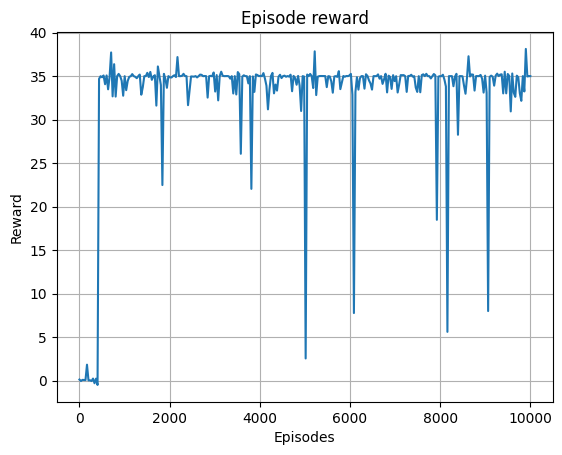

In [15]:
# print(agent.v_max)
import matplotlib.pyplot as plt
from scipy.stats import sem  # 标准误差
from scipy.interpolate import make_interp_spline
x=np.arange(T)
x_smooth = np.linspace(x.min(), x.max(), 300) 
spl_mean = make_interp_spline(x, rewards, k=3)  # B样条插值

y_smooth = spl_mean(x_smooth)


# 绘图
# 绘制均值曲线
plt.plot(x_smooth, y_smooth, label='Mean Reward')
# 绘制置信区间的阴影
plt.title('Episode reward')
plt.xlabel('Episodes')
plt.ylabel('Reward')
# plt.legend()
plt.grid(True)  # 添加网格
plt.show()

In [18]:
# plot routine
import matplotlib.pyplot as plt
from scipy.stats import sem  # 标准误差
from scipy.interpolate import make_interp_spline
def plot(N,rewards,T):
    mean_reward=np.mean(rewards,axis=0)
    std_err=sem(rewards,axis=0) #calculate standard error

    #calculate confidence interval
    confidence_interval=1.96*std_err #95%

    x=np.arange(T)

    # smoothen the curve
    x_smooth = np.linspace(x.min(), x.max(), 300) 
    spl_mean = make_interp_spline(x, mean_reward, k=3)  # B样条插值

    y_smooth = spl_mean(x_smooth)

    spl_ci_upper = make_interp_spline(x, mean_reward + confidence_interval, k=3)
    y_smooth_upper = spl_ci_upper(x_smooth)

    spl_ci_lower = make_interp_spline(x, mean_reward - confidence_interval, k=3)
    y_smooth_lower = spl_ci_lower(x_smooth)


    # 绘图
    # 绘制均值曲线
    plt.plot(x_smooth, y_smooth, label='Mean Reward')
    # 绘制置信区间的阴影
    plt.fill_between(x_smooth, y_smooth_lower, y_smooth_upper, color='b', alpha=0.2, label='95% CI')
    plt.title('Episode reward')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    # plt.legend()
    plt.grid(True)  # 添加网格
    plt.show()

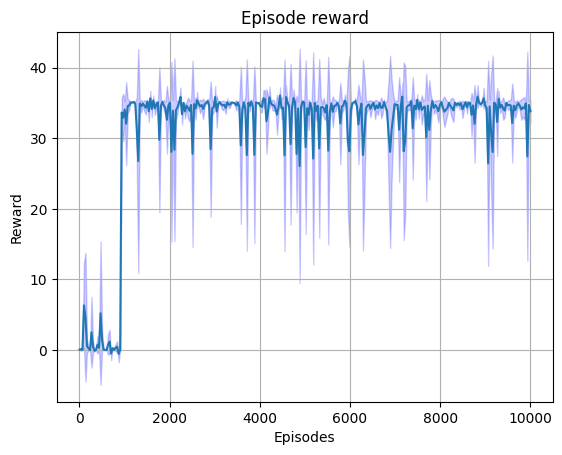

In [21]:
plot(N,rewards,T)
np.save("rewards_4room_3size_Hybrid",rewards)

In [11]:
np.save("rewards_4room_3size_Online_0.00002_5agent.npy",rewards)

In [ ]:
env2.enable_rendering()

for _ in range(5):
    observation,info=env2.reset()
    for h in range(horizon):
        action=agent.policy(observation,h)
        observation,reward,terminated,truncated,info=env2.step(action)
        done=terminated or truncated
        if done:
            break
env2.render()
video=env2.save_video("_video/video_plot_rooms.mp4")

In [ ]:

# chain of length 10. With proba 0.1, the agent will not be able to take the action it wants to take.
ucbvi_params={'gamma':1,"horizon":14,"writer_extra":"reward"}
random_params={"writer_extra":"reward"}
env_kwargs=dict(nrooms=3,remove_walls=False,room_size=2,initial_state_distribution="center",include_traps=True)
ucbvi_stats=ExperimentManager(
    AdaptiveAgent,
    (NRoom,env_kwargs),
    fit_budget=10000,
    eval_kwargs=dict(eval_horizon=14,n_simulation=10),
    init_kwargs=ucbvi_params,
    n_fit=1,
    agent_name="AdaptiveAgent",
)
ucbvi_stats.fit()

In [ ]:
# Plot of the reward.
output = plot_writer_data(
    [ucbvi_stats],
    tag="reward",
    title="Episode Reward",
)


# Plot of the reward.
output = plot_writer_data(
    [ucbvi_stats],
    tag="reward",
    smooth=True,
    title="Episode Reward smoothed",
)